In [1]:
from trainer import *
import cv2


with open('configs/basic_config.yaml') as file:
    config = yaml.full_load(file)
 
trainer = Trainer(config)


Loading Pretrained model..
Initializing samples..


In [2]:
dataset = trainer.dataset
s = dataset.__getitem__(10)

array([0.33553426, 0.01814677, 1.10474336])

array([-0.30135079, -0.0188718 , -0.99963057])

In [3]:
def plt_tensor(img, proj_img=False):
    img = (np.transpose(img.cpu().numpy(), (1, 2, 0)))
    
    print(img.shape)
    
    if not proj_img:
        img = 0.449 + (img * 0.2)
    return img

# Create a sample

In [4]:
batch    = next(iter(trainer.train_loader))

In [5]:
tgt        = batch['tgt']
ref_imgs   = batch['ref_imgs']
intrinsics = batch['intrinsics']
poses      = batch['oxts']
depth      = batch['groundtruth']
batch_option  = 0
pose_option   = 0

(384, 1280, 3)
(384, 1280, 3)
(384, 1280, 3)


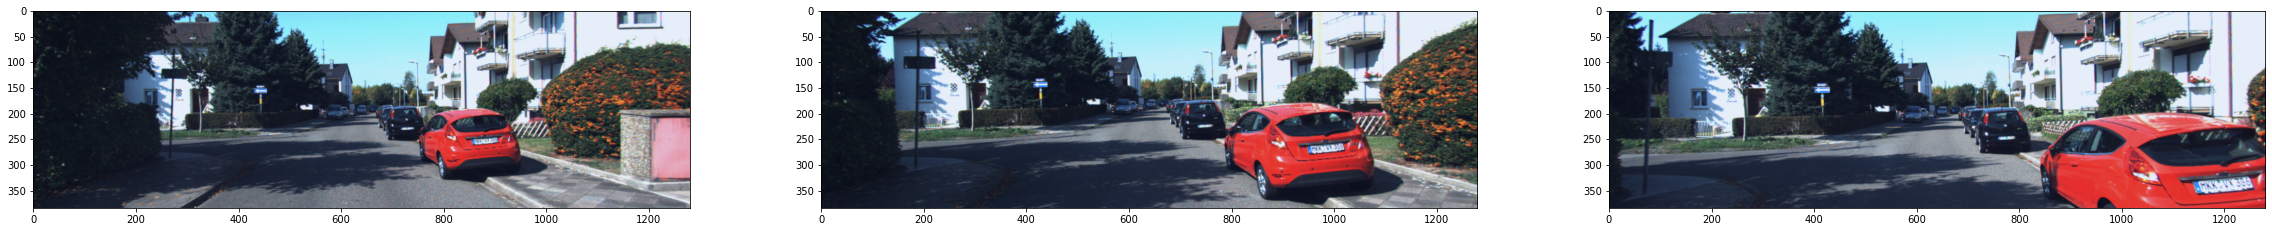

In [6]:

tgt_img = tgt[batch_option]
ref_img = ref_imgs[pose_option][batch_option]
K = intrinsics[batch_option]

fig, axs = plt.subplots(1, 3, figsize=(40, 10)) 
axs[0].imshow(plt_tensor(ref_imgs[0][1]))
axs[1].imshow(plt_tensor(tgt[1]))
axs[2].imshow(plt_tensor(ref_imgs[1][1]))


In [ ]:
C, H, W = depth.shape
depth = depth.view(C, -1)
val, _= depth.max(1)
val = val.unsqueeze(1)

print(depth[0].max())

depth = depth.sub(val)
depth = depth.reshape(C, H, W )
print(depth[0].max())

In [ ]:
def create_mul_mask(tensor):
    
    mul_mask = torch.ones_like(tensor)
    
    C, H, W     = mul_mask.shape
    c_h, c_w = H//2, W//2
    
    mul_mask[:, c_h-150:c_h+150, c_w-500:c_w+500] = 2
    mul_mask[:, c_h-100:c_h+100, c_w-300:c_w+300] = 5
    mul_mask[:, c_h-50:c_h+50, c_w-100:c_w+100]   = 10
    
    return mul_mask

mask = create_mul_mask(depth)
print(mask.shape)
plot_img = mask.cpu().detach().numpy()
plt.imshow(plot_img[3])

In [ ]:
new = depth * mask

# Inference

In [8]:
one_sample = trainer.dataset.__getitem__(100)


# load a depth model
depth_model = trainer.depth_model
# depth_model.load_state_dict(depth_model_state_dict)
depth_model.eval()

# load a pose model
pose_model = trainer.pose_model
# pose_model.load_state_dict(pose_model_state_dict)
pose_model.eval()

# test input image
input_imgs = one_sample['tgt'].unsqueeze(0).to(trainer.device)
ref_imgs   = [img.unsqueeze(0).to(trainer.device) for img in one_sample['ref_imgs']]

with torch.no_grad():
    # test and plot
    depth = depth_model(input_imgs)
    pose  = pose_model(input_imgs, ref_imgs)

print(depth)
print(pose)



[tensor([[[[2.0078e-12, 2.0079e-12, 2.0080e-12,  ..., 2.0017e-12,
           2.0018e-12, 2.0018e-12],
          [2.0079e-12, 2.0079e-12, 2.0080e-12,  ..., 2.0017e-12,
           2.0017e-12, 2.0017e-12],
          [2.0080e-12, 2.0080e-12, 2.0081e-12,  ..., 2.0016e-12,
           2.0016e-12, 2.0016e-12],
          ...,
          [2.0060e-12, 2.0060e-12, 2.0060e-12,  ..., 1.9997e-12,
           1.9997e-12, 1.9997e-12],
          [2.0060e-12, 2.0060e-12, 2.0061e-12,  ..., 1.9998e-12,
           1.9998e-12, 1.9998e-12],
          [2.0060e-12, 2.0060e-12, 2.0061e-12,  ..., 1.9998e-12,
           1.9998e-12, 1.9998e-12]]]], device='cuda:0'), tensor([[[[0.0205, 0.0205, 0.0205,  ..., 0.0205, 0.0205, 0.0205],
          [0.0205, 0.0205, 0.0205,  ..., 0.0205, 0.0205, 0.0205],
          [0.0205, 0.0205, 0.0205,  ..., 0.0205, 0.0205, 0.0205],
          ...,
          [0.0205, 0.0205, 0.0205,  ..., 0.0205, 0.0205, 0.0205],
          [0.0205, 0.0205, 0.0205,  ..., 0.0205, 0.0205, 0.0205],
          [0

/home/mcav/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


array([[2.0078240e-12, 2.0078661e-12, 2.0079773e-12, ..., 2.0017440e-12,
        2.0017518e-12, 2.0017594e-12],
       [2.0078661e-12, 2.0078854e-12, 2.0080040e-12, ..., 2.0017328e-12,
        2.0017404e-12, 2.0017404e-12],
       [2.0079736e-12, 2.0080040e-12, 2.0081267e-12, ..., 2.0016144e-12,
        2.0016259e-12, 2.0016298e-12],
       ...,
       [2.0059867e-12, 2.0059904e-12, 2.0060481e-12, ..., 1.9996988e-12,
        1.9997140e-12, 1.9997255e-12],
       [2.0060327e-12, 2.0060327e-12, 2.0060941e-12, ..., 1.9997712e-12,
        1.9998018e-12, 1.9998057e-12],
       [2.0060212e-12, 2.0060364e-12, 2.0060824e-12, ..., 1.9997825e-12,
        1.9998057e-12, 1.9998133e-12]], dtype=float32)

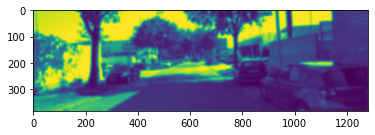

In [14]:
img = depth[0].squeeze().cpu().detach().numpy()
plt.imshow(img/img.mean())
img

In [ ]:
def disp_to_depth(disp, min_depth=0.1, max_depth=100.0):
        """Convert network's sigmoid output into depth prediction
        The formula for this conversion is given in the 'additional considerations'
        section of the paper.
        """
        min_disp = 1 / max_depth
        max_disp = 1 / min_depth

        scaled_disp = min_disp + (max_disp - min_disp) * disp
        depth = 1 / scaled_disp
        return depth

depth = disp_to_depth(img)

plt.imshow(depth)
depth

In [ ]:
depth = norm * create_mul_mask(torch.tensor(depth))
plt.imshow(depth)
depth.max()

In [ ]:
from __future__ import absolute_import, division, print_function

import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers, pretrained, num_input_images=1):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        # x = (input_image - 0.45) / 0.225
        x = input_image
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

In [ ]:
# Adapted from monodepth2
# https://github.com/nianticlabs/monodepth2/blob/master/layers.py

from __future__ import absolute_import, division, print_function

import torch.nn as nn
import torch.nn.functional as F


def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth


class ConvBlock(nn.Module):
    """Layer to perform a convolution followed by ELU
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out


class Conv3x3(nn.Module):
    """Layer to pad and convolve input
    """
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()

        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out


def upsample(x):
    """Upsample input tensor by a factor of 2
    """
    return F.interpolate(x, scale_factor=2, mode="nearest")


In [ ]:
from collections import OrderedDict


class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(DepthDecoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips
        self.upsample_mode = 'nearest'
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [upsample(x)]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs

In [ ]:
decoder_model = DepthDecoder(model.num_ch_enc)
model = ResnetEncoder(18, True)

In [ ]:
output = model(tgt)
output = decoder_model(output)
disp   = 10 * output[('disp', 0)][0] +0.01
depth  = 1/disp

In [ ]:
depth = depth.squeeze().cpu().detach().numpy()
plt.imshow(depth)